In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import matplotlib as mpl
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
from datetime import timedelta, time
import numpy as np 
from collections import Counter

In [15]:
def fix_name(name):
    trans = {
        'jaroslav':'iaroslav',
        'zabaikal':'transbai',
        'primorie':'primor',
        'sebastop':'sevastop',
        'saratovs':'saratov',
        'voronezh':'voron'
    }
    if name in trans.keys():
        return(trans[name])
    return(name)


def clear_region_name(region_name):
    drop_words = [' kray', ' krai',' oblast', ' obl', ' republic', 'republic of ']+[x for x in '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~’ ']
    region_name = region_name.lower()
    for drop_word in drop_words:
        region_name = region_name.replace(drop_word, '')
    return(fix_name(region_name[:8].replace('y','i')))

def get_local_time(events):
    regions = pd.read_csv('regions_dict.csv')
    events['region_for_time'] = events['region'].apply(clear_region_name)
    events['event_time'] = pd.to_datetime(events['event_timestamp'].apply(lambda x: x.replace('+03:00','')))
    events = events.merge(regions.rename(columns = {'region':'region_for_time'}), how = 'left', left_on = 'region_for_time', right_on = 'region_for_time')
    events['hours_corrector'] = events['hours_corrector'].fillna(0) 
    events['local_event_time'] = events['event_time'] + events['hours_corrector'].astype('timedelta64[h]')
    events['local_event_timestamp'] = events['local_event_time'].dt.time

    return(events)

## Сбор и обработка данных 

In [4]:
train = pd.read_csv('train_events.csv')
targets = pd.read_csv('train_targets.csv')

video = pd.read_csv('video_info_v2.csv')
all_events = pd.read_csv('all_events.csv')


In [5]:
print(train.shape,train['event_timestamp'].min(),train['event_timestamp'].max())
print(train.columns)

print(targets.shape)
print(targets.columns)

print(video.shape)
print(video.columns)


print(all_events.shape,train['event_timestamp'].min(),train['event_timestamp'].max())
print(all_events.columns)

(1759616, 9) 2024-06-01 00:00:02+03:00 2024-06-30 23:59:26+03:00
Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid'],
      dtype='object')
(180012, 4)
Index(['viewer_uid', 'age', 'sex', 'age_class'], dtype='object')
(481480, 5)
Index(['rutube_video_id', 'title', 'category', 'duration', 'author_id'], dtype='object')
(8439624, 9) 2024-06-01 00:00:02+03:00 2024-06-30 23:59:26+03:00
Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid'],
      dtype='object')


In [16]:
local_time = get_local_time(train)

In [144]:
local_time_all = get_local_time(all_events)

In [19]:
train_full = train.merge(local_time[['viewer_uid','rutube_video_id','event_timestamp','local_event_time']],how='left',on= ['viewer_uid','event_timestamp','rutube_video_id'])
train_full = train_full.merge(targets, how = 'left', on =['viewer_uid'])
train_full = train_full.merge(video,how ='left', on =['rutube_video_id'])

In [8]:
all_events = all_events.merge(video,how='left',on=['rutube_video_id'])

In [84]:
all_events['region'].value_counts(normalize=True)

Moscow                             0.211856
St.-Petersburg                     0.067175
Moscow Oblast                      0.056246
Sverdlovsk Oblast                  0.039520
Samara Oblast                      0.037097
Krasnodar Krai                     0.036940
Krasnoyarsk Krai                   0.034150
Novosibirsk Oblast                 0.032306
Bashkortostan Republic             0.030356
Tatarstan Republic                 0.023331
Nizhny Novgorod Oblast             0.021851
Rostov                             0.020387
Chelyabinsk                        0.019411
Leningradskaya Oblast'             0.018721
Khabarovsk                         0.016630
Tver Oblast                        0.016100
Yaroslavl Oblast                   0.014813
Perm Krai                          0.014381
Orenburg Oblast                    0.014163
Irkutsk Oblast                     0.012454
Stavropol Kray                     0.011429
Primorye                           0.010644
Saratov Oblast                  

In [21]:
train_full['local_event_time']= pd.to_datetime(train_full['local_event_time'])

train_full['morningflag'] = (train_full.local_event_time.dt.hour >= 6) & (train_full.local_event_time.dt.hour <12)
train_full['dayflag'] = (train_full.local_event_time.dt.hour >= 12) & (train_full.local_event_time.dt.hour <=22)
train_full['nightflag'] = np.where(train_full.local_event_time.dt.hour.isin([23,0,1,2,3,4,5]), True, False)

train_full['local_event_time']= pd.to_datetime(train_full['local_event_time'])

train_full['hours'] = train_full['local_event_time'].dt.time

train_full['dt_format'] = train_full['local_event_time'].dt.strftime('%Y-%m-%d')

train_full.loc[train_full.sex =='female','sex_flag_female'] = 1
train_full.loc[train_full.sex !='female','sex_flag_female'] = 0

train_full.loc[train_full.sex =='male','sex_flag_male'] = 1
train_full.loc[train_full.sex !='male','sex_flag_male'] = 0


train_full['day_of_week']= train_full.local_event_time.dt.day_name()

train_full.loc[train_full.day_of_week =='Saturday','weekend'] = 1
train_full.loc[train_full.day_of_week =='Sunday','weekend'] = 1

train_full.weekend.fillna(0,inplace=True)

In [147]:
all_events = all_events.merge(local_time_all[['viewer_uid','rutube_video_id','event_timestamp','local_event_time']],how='left',on= ['viewer_uid','event_timestamp','rutube_video_id'])
all_events = all_events.merge(video,how ='left', on =['rutube_video_id'])

all_events['local_event_time']= pd.to_datetime(all_events['local_event_time'])

all_events['morningflag'] = (all_events.local_event_time.dt.hour >= 6) & (all_events.local_event_time.dt.hour <12)
all_events['dayflag'] = (all_events.local_event_time.dt.hour >= 12) & (all_events.local_event_time.dt.hour <=22)
all_events['nightflag'] = np.where(all_events.local_event_time.dt.hour.isin([23,0,1,2,3,4,5]), True, False)

all_events['local_event_time']= pd.to_datetime(all_events['local_event_time'])

all_events['hours'] = all_events['local_event_time'].dt.time

all_events['dt_format'] = all_events['local_event_time'].dt.strftime('%Y-%m-%d')

all_events['day_of_week']= all_events.local_event_time.dt.day_name()

all_events.loc[all_events.day_of_week =='Saturday','weekend'] = 1
all_events.loc[all_events.day_of_week =='Sunday','weekend'] = 1

all_events.weekend.fillna(0,inplace=True)

In [25]:
month_mean_serie = train_full.groupby('dt_format')['viewer_uid'].mean()
train_full['mean_month'] = train_full['dt_format'].map(month_mean_serie)

train_full['hour_num'] = train_full['local_event_time'].dt.hour
col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_train = train_full.groupby([train_full['local_event_time'].dt.hour, train_full['day_of_week']]).viewer_uid.count().reset_index().dropna()



In [148]:
month_mean_serie = all_events.groupby('dt_format')['viewer_uid'].mean()
all_events['mean_month'] = all_events['dt_format'].map(month_mean_serie)

all_events['hour_num'] = all_events['local_event_time'].dt.hour
col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_all = all_events.groupby([all_events['local_event_time'].dt.hour, all_events['day_of_week']]).viewer_uid.count().reset_index().dropna()



## Аналитика

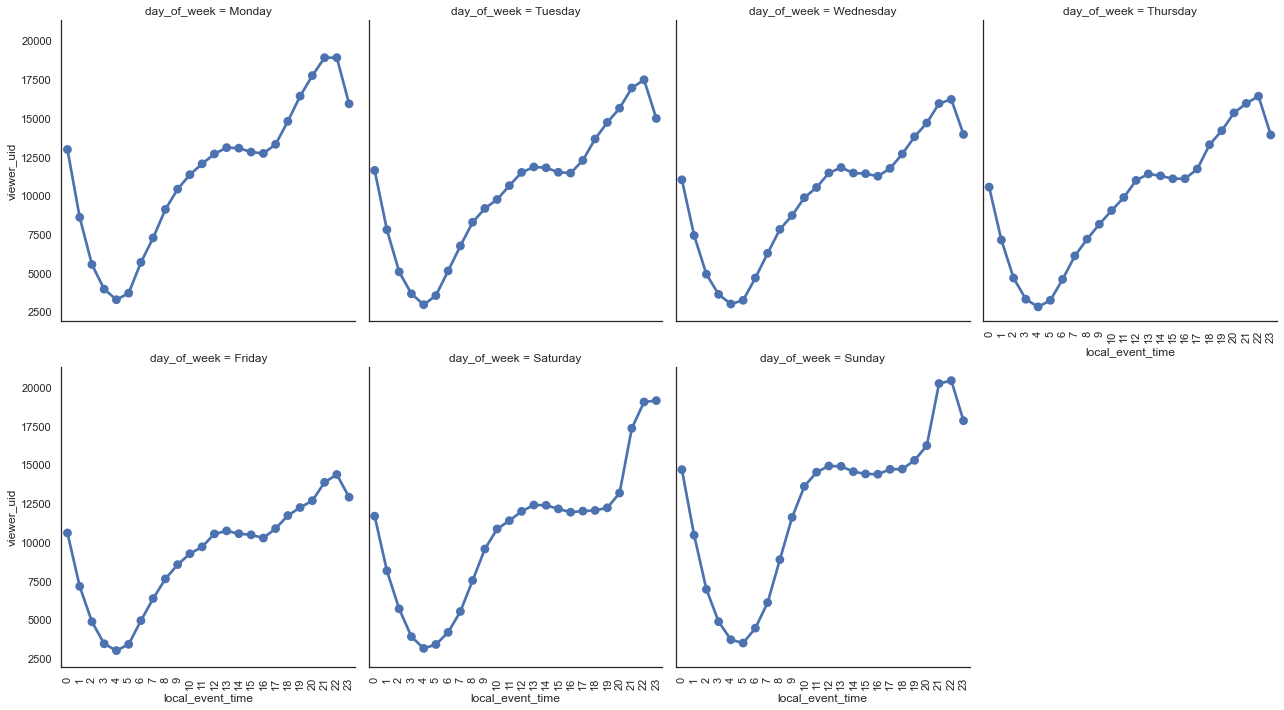

In [82]:
ax = sns.catplot(x="local_event_time", y="viewer_uid", col="day_of_week",col_order=col_order,
                data=df_train, ci=None,aspect=0.9,col_wrap=4,kind="point")
ax.set_xticklabels(rotation=90)
#ax.set_title('Активность пользователей по дням недели и времени')

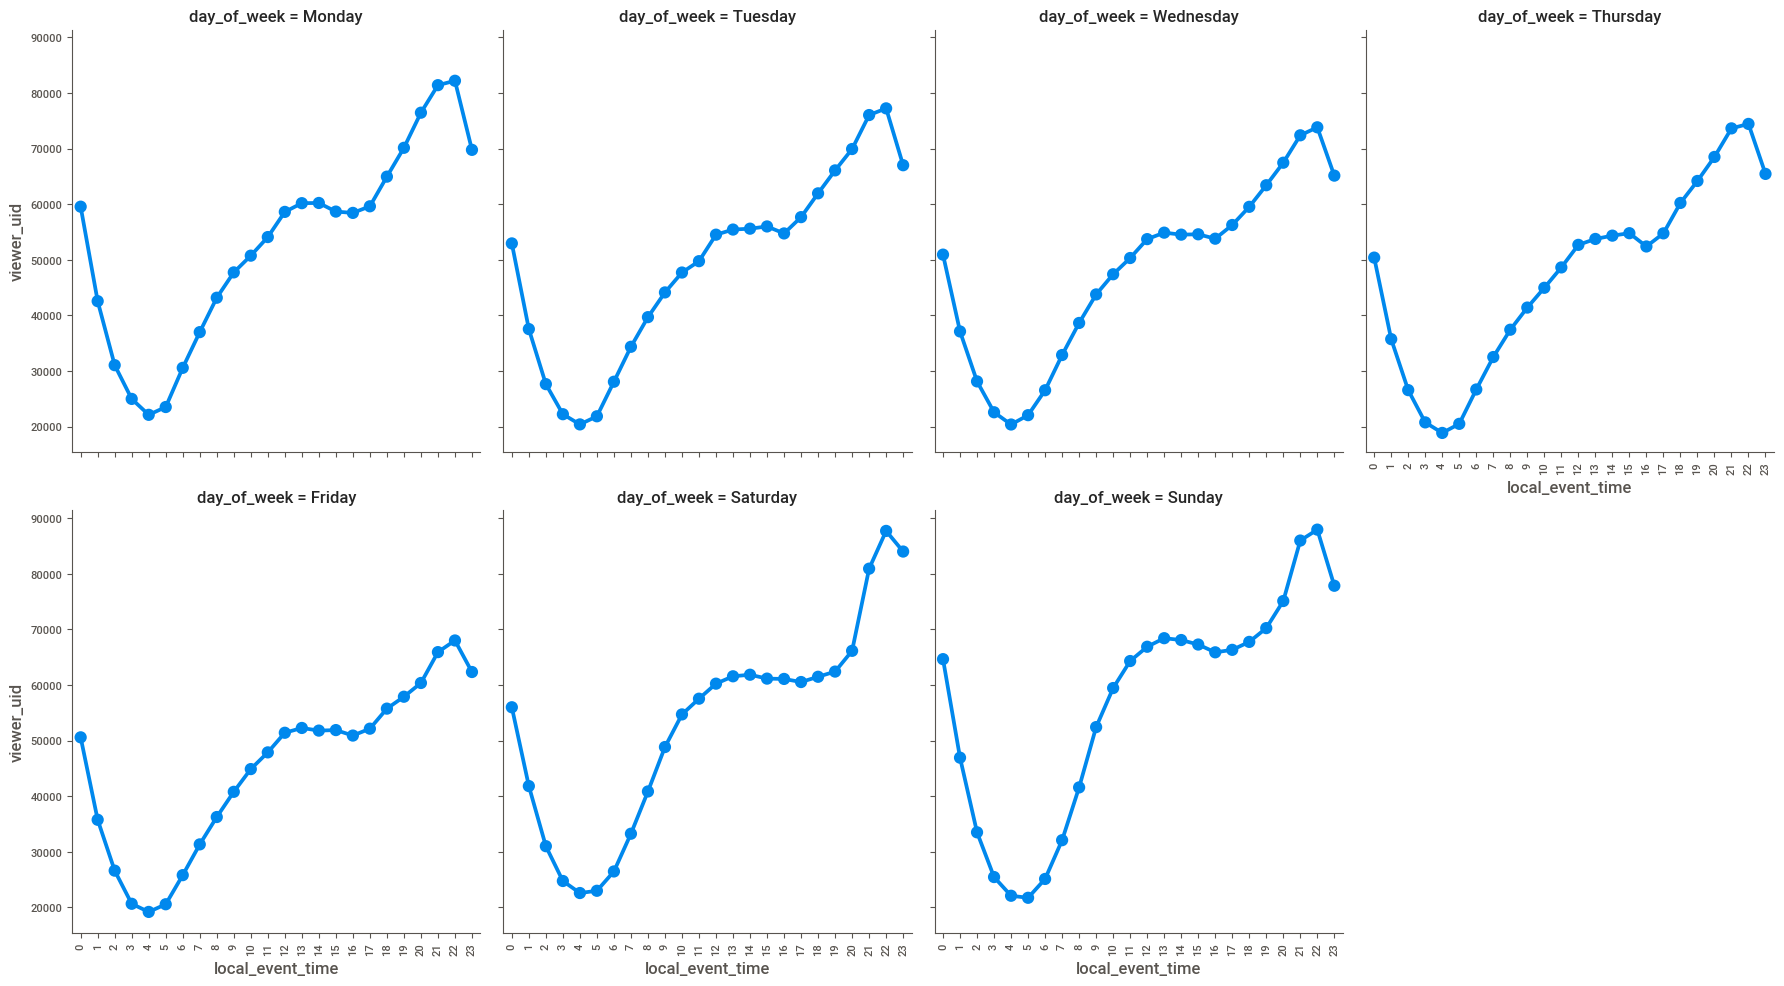

In [149]:
ax = sns.catplot(x="local_event_time", y="viewer_uid", col="day_of_week",col_order=col_order,
                data=df_all, ci=None,aspect=0.9,col_wrap=4,kind="point")
ax.set_xticklabels(rotation=90)

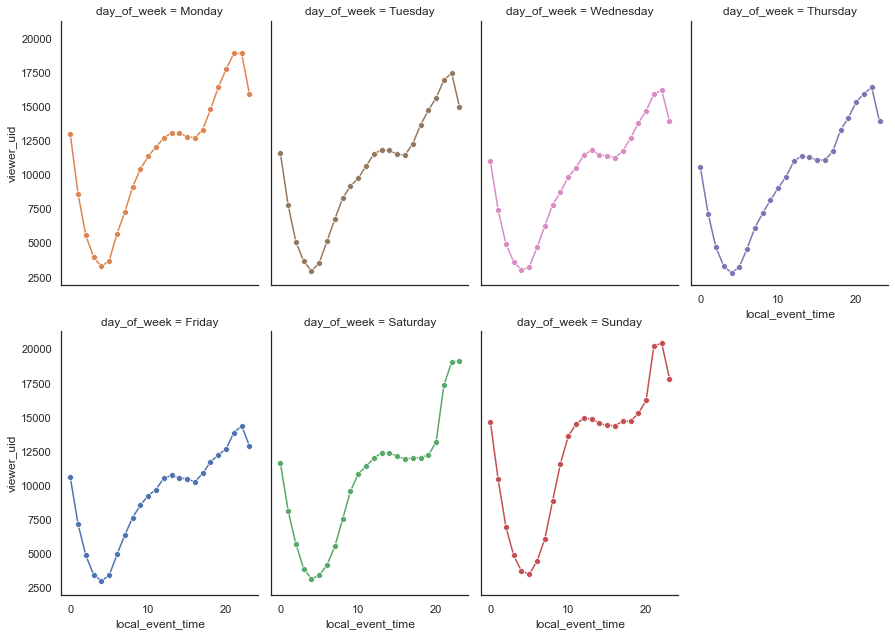

In [76]:
g = sns.FacetGrid(df_train, hue="day_of_week", col="day_of_week",sharey=True,col_wrap=4,height=4.5, aspect=0.7,col_order=col_order)
g = g.map(sns.lineplot, "local_event_time", "viewer_uid", marker='o')

In [83]:
train_full['region'].value_counts(dropna=False,normalize=True)*100

Moscow                             0.218137
Moscow Oblast                      0.067319
St.-Petersburg                     0.066603
Sverdlovsk Oblast                  0.040464
Krasnodar Krai                     0.040104
Novosibirsk Oblast                 0.032026
Bashkortostan Republic             0.027251
Samara Oblast                      0.027053
Nizhny Novgorod Oblast             0.025919
Chelyabinsk                        0.023777
Tatarstan Republic                 0.021665
Rostov                             0.021355
Krasnoyarsk Krai                   0.017050
Perm Krai                          0.016476
Leningradskaya Oblast'             0.015149
Yaroslavl Oblast                   0.014214
Irkutsk Oblast                     0.013712
Saratov Oblast                     0.013056
Voronezh Oblast                    0.012423
Stavropol Kray                     0.011570
Primorye                           0.011341
Khabarovsk                         0.010443
Volgograd Oblast                

In [141]:
train_full['total_watchtime_minutes'] = train_full.total_watchtime/60
all_events['total_watchtime_minutes'] = all_events.total_watchtime/60

train_full['duration_minutes'] = train_full.duration/60000
all_events['duration_minutes'] = all_events.duration/60000

In [98]:
df_watch_time= train_full.groupby([train_full['region']]).total_watchtime_minutes.mean().reset_index().dropna()

In [102]:
df_watch_time.sort_values(by='total_watchtime_minutes',ascending=False)

,region,total_watchtime_minutes
24,Kabardino-Balkariya Republic,48.150676
57,Nenets,43.771429
82,Sebastopol City,43.038266
78,Sakhalin Oblast,42.534184
22,Jaroslavl,42.350112
33,Kemerovo Oblast,42.296577
110,Vologda Oblast,42.021778
1,Altai,41.721784
16,Crimea,41.488105
112,Voronezj,41.236799


In [106]:
df_watch_time_median= train_full.groupby([train_full['region']]).total_watchtime_minutes.median().reset_index().dropna()
df_watch_time_median.sort_values(by='total_watchtime_minutes',ascending=False)

,region,total_watchtime_minutes
112,Voronezj,39.933333
22,Jaroslavl,39.875000
1,Altai,39.833333
72,Primorskiy (Maritime) Kray,39.608333
78,Sakhalin Oblast,39.500000
82,Sebastopol City,39.250000
77,Sakha,38.325000
4,Arkhangelsk Oblast,38.216667
19,Irkutsk Oblast,38.133333
48,Kuzbass,37.983333


In [142]:
train_full['diff_between_duration_and_actual']=train_full['duration_minutes']-train_full['total_watchtime_minutes']
all_events['diff_between_duration_and_actual']=all_events['duration_minutes']-all_events['total_watchtime_minutes']


In [110]:
df_watch_time_act= train_full.groupby([train_full['region']]).diff_between_duration_and_actual.mean().reset_index().dropna()
df_watch_time_act.sort_values(by='diff_between_duration_and_actual',ascending=True)

,region,diff_between_duration_and_actual
24,Kabardino-Balkariya Republic,12.522162
87,Stavropol Krai,13.262572
18,Ingushetiya Republic,14.789596
4,Arkhangelsk Oblast,15.836473
109,Vologda,17.668915
103,Tyva Republic,17.727869
110,Vologda Oblast,17.745407
100,Tver’ Oblast,18.129971
59,North Ossetia,18.707836
28,Kaluga,18.830687


In [111]:
my_report = sv.compare([train_full[(train_full['region']=='St.-Petersburg')|(train_full['region']=='Moscow')|(train_full['region']=='Moscow Oblast')], "Big cities"], [train_full[(train_full['region']!='St.-Petersburg')&(train_full['region']!='Moscow')&(train_full['region']!='Moscow Oblast')], "Regions"])
my_report.show_html('comparing moscow, st petersburg with other regions.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing moscow, st petersburg with other regions.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [135]:
train_full['fake1']=1 
group_data = train_full.groupby(['day_of_week','morningflag','dayflag','nightflag','weekend','sex']).agg(
cnt= ('viewer_uid','count'),
age = ('age','mean'),
age_mode= ('age','median'),
age_min = ('age','min'),
age_max = ('age','max'))
group_data

cnt        age  \
day_of_week morningflag dayflag nightflag weekend sex                         
Friday      False       False   True      0.0     female   25082  31.676381   
                                                  male     20233  35.423417   
                        True    False     0.0     female   78539  31.431722   
                                                  male     49692  36.086553   
            True        False   False     0.0     female   28071  32.141997   
                                                  male     18330  36.280578   
Monday      False       False   True      0.0     female   31801  31.901513   
                                                  male     22178  35.416539   
                        True    False     0.0     female  106577  31.534046   
                                                  male     57857  35.957309   
            True        False   False     0.0     female   36842  32.156343   
                                                  male     19035  36.212818   
Saturday    False       False   True      1.0     female   31852  31.817719   
                                                  male     23217  35.449671   
                        True    False     1.0     female   88364  31.416108   
                                                  male     58271  36.118155   
            True        False   False     1.0     female   29465  32.199864   
                                                  male     19537  36.499872   
Sunday      False       False   True      1.0     female   37075  31.824167   
                                                  male     24869  35.381841   
                        True    False     1.0     female  113083  31.374300   
                                                  male     61615  35.853915   
            True        False   False     1.0     female   38423  32.202014   
                                                  male     20679  36.423376   
Thursday    False       False   True      0.0     female   25348  31.681789   
                                                  male     20278  35.223000   
                        True    False     0.0     female   87483  31.411874   
                                                  male     55227  36.071070   
            True        False   False     0.0     female   27533  31.992663   
                                                  male     17409  36.425010   
Tuesday     False       False   True      0.0     female   28628  31.882912   
                                                  male     21002  35.627464   
                        True    False     0.0     female   93827  31.491831   
                                                  male     54965  36.094078   
            True        False   False     0.0     female   31890  32.155221   
                                                  male     17836  36.339089   
Wednesday   False       False   True      0.0     female   26636  31.817390   
                                                  male     20535  35.386511   
                        True    False     0.0     female   88320  31.477774   
                                                  male     54138  36.004932   
            True        False   False     0.0     female   29676  32.254718   
                                                  male     18198  36.489120   

                                                          age_mode  age_min  \
day_of_week morningflag dayflag nightflag weekend sex                         
Friday      False       False   True      0.0     female      31.0       11   
                                                  male        36.0       11   
                        True    False     0.0     female      31.0       11   
                                                  male        36.0       11   
            True        False   False     0.0     female      31.0       11   
                               

In [137]:
groupby_id_region = pd.DataFrame(train_full.groupby("viewer_uid")["region"].nunique()) 
len(groupby_id_region[groupby_id_region['region']!=1])/len(groupby_id_region)

0.3987178632535609

In [138]:
my_report = sv.compare([train_full[train_full['viewer_uid'].isin(groupby_id_region[groupby_id_region['region']==1].index)], "Equal 1"], [train_full[train_full['viewer_uid'].isin(groupby_id_region[groupby_id_region['region']!=1].index)], "Equal non 1"])
my_report.show_html('comparing region1 and non 1.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing region1 and non 1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [60]:
my_report = sv.compare([train_full[(train_full['region']=='St.-Petersburg')|(train_full['region']=='Moscow')|(train_full['region']=='Moscow Oblast')], "Big cities"], [train_full[(train_full['region']!='St.-Petersburg')&(train_full['region']!='Moscow')&(train_full['region']!='Moscow Oblast')], "Regions"])
my_report.show_html('comparing moscow, st petersburg with other regions.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing moscow, st petersburg with other regions.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [151]:
my_report = sv.compare([train_full, "train_full"], [all_events, "all_events"])
my_report.show_html('comparing train_full and all_events.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing train_full and all_events.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [139]:
my_report = sv.compare([all_events, "all_events"], [train_full, "train_full"])
my_report.show_html('comparing all_events and train.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing all_events and train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [133]:
my_report = sv.compare([train_full[train_full['sex']=='female'], "female"], [train_full[train_full['sex']=='male'], "male"])
my_report.show_html('comparing train_female and train_male.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing train_female and train_male.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [134]:
my_report = sv.compare([train_full[train_full['sex']=='male'], "male"], [train_full[train_full['sex']=='female'], "female"])
my_report.show_html('comparing train_male and train_female.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing train_male and train_female.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [136]:
my_report = sv.compare([train_full[(train_full['region']=='St.-Petersburg')|(train_full['region']=='Moscow')|(train_full['region']=='Moscow Oblast')&(train_full['sex']=='male')], "big city man"], [train_full[(train_full['region']!='St.-Petersburg')&(train_full['region']!='Moscow')&(train_full['region']!='Moscow Oblast')&(train_full['sex']=='male')], "region man"])
my_report.show_html('comparing train_male_bigcity and train_male_region.html')

                                             |      | [  0%]   00:00 -> (? left)

Report comparing train_male_bigcity and train_male_region.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [200]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['duration_minutes'].value_counts(normalize=True,ascending=False).reset_index()


In [202]:
print(full_age_value_counts[full_age_value_counts['age_class']==0]['duration_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==0]['duration_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==1]['duration_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==1]['duration_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==2]['duration_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==2]['duration_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==3]['duration_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==3]['duration_minutes'].mean())

41.927233333333334 44.412971382522166
41.801874999999995 43.05906393792253
41.21695 43.21174953170953
40.19338333333333 42.881735236154725


In [203]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['total_watchtime_minutes'].value_counts(normalize=True,ascending=False).reset_index()


In [204]:
print(full_age_value_counts[full_age_value_counts['age_class']==0]['total_watchtime_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==0]['total_watchtime_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==1]['total_watchtime_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==1]['total_watchtime_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==2]['total_watchtime_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==2]['total_watchtime_minutes'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==3]['total_watchtime_minutes'].median(),full_age_value_counts[full_age_value_counts['age_class']==3]['total_watchtime_minutes'].mean())

63.21666666666667 68.0170226494016
98.56666666666666 118.96309169711911
104.56666666666666 129.4760577667437
94.32499999999999 108.47630869899945


In [205]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['diff_between_duration_and_actual'].value_counts(normalize=True,ascending=False).reset_index()


In [206]:
print(full_age_value_counts[full_age_value_counts['age_class']==0]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==0]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==1]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==1]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==2]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==2]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==3]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==3]['diff_between_duration_and_actual'].mean())

12.89293333333333 24.60787605659485
15.250816666666669 24.864823001994964
15.125608333333332 25.705283894574357
12.87148333333333 26.419028252997748


In [214]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['day_of_week'].value_counts(normalize=True,ascending=True).reset_index()
full_age_value_counts

,index,age_class,day_of_week,proportion
0,0,0,Friday,0.122147
1,1,0,Wednesday,0.131107
2,2,0,Thursday,0.132977
3,3,0,Tuesday,0.135526
4,4,0,Saturday,0.147231
5,5,0,Monday,0.149811
6,6,0,Sunday,0.181200
7,7,1,Friday,0.124075
8,8,1,Thursday,0.132100
9,9,1,Wednesday,0.134617


In [212]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['nightflag'].value_counts(normalize=True,ascending=True).reset_index()
full_age_value_counts

,index,age_class,nightflag,proportion
0,0,0,True,0.194820
1,1,0,False,0.805180
2,2,1,True,0.202548
3,3,1,False,0.797452
4,4,2,True,0.206782
5,5,2,False,0.793218
6,6,3,True,0.202513
7,7,3,False,0.797487


In [209]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['dayflag'].value_counts(normalize=True,ascending=False).reset_index()
full_age_value_counts

,index,age_class,dayflag,proportion
0,0,0,True,0.632940
1,1,0,False,0.367060
2,2,1,True,0.606036
3,3,1,False,0.393964
4,4,2,True,0.586736
5,5,2,False,0.413264
6,6,3,True,0.586319
7,7,3,False,0.413681


In [211]:
full_age_value_counts = train_full.groupby('age_class', as_index=False)['morningflag'].value_counts(normalize=True,ascending=True).reset_index()
full_age_value_counts

,index,age_class,morningflag,proportion
0,0,0,True,0.172240
1,1,0,False,0.827760
2,2,1,True,0.191417
3,3,1,False,0.808583
4,4,2,True,0.206482
5,5,2,False,0.793518
6,6,3,True,0.211168
7,7,3,False,0.788832


In [ ]:
print(full_age_value_counts[full_age_value_counts['age_class']==0]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==0]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==1]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==1]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==2]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==2]['diff_between_duration_and_actual'].mean())
print(full_age_value_counts[full_age_value_counts['age_class']==3]['diff_between_duration_and_actual'].median(),full_age_value_counts[full_age_value_counts['age_class']==3]['diff_between_duration_and_actual'].mean())

In [152]:
top_categories_train = pd.DataFrame(train_full['category'].value_counts(normalize=True)[:17])
top_categories_train

,category
Телепередачи,0.467771
Сериалы,0.236678
Фильмы,0.060350
Разное,0.032151
Развлечения,0.025579
Обучение,0.024352
Интервью,0.021942
Юмор,0.020532
Видеоигры,0.018754
Лайфстайл,0.011029


In [155]:
train_full[~train_full['category'].isin(top_categories_train.index)]['category'].value_counts(normalize=True)

Наука                           0.120440
Эзотерика                       0.116504
Путешествия                     0.103257
Красота                         0.101626
Авто-мото                       0.099392
Здоровье                        0.069175
Бизнес и предпринимательство    0.057418
Культура                        0.048357
Хобби                           0.039544
Сад и огород                    0.036299
Техника и оборудование          0.035767
Обзоры и распаковки товаров     0.033071
Психология                      0.030784
Аудиокниги                      0.024968
Строительство и ремонт          0.019471
Лайфхаки                        0.014736
Люди и блоги                    0.011562
Аудио                           0.010923
Животные                        0.007820
Охота и рыбалка                 0.006579
Природа                         0.006260
Недвижимость                    0.004008
Дизайн                          0.002039
Name: category, dtype: float64

In [154]:
all_events[~all_events['category'].isin(top_categories_train.index)]['category'].value_counts(normalize=True)

Путешествия                     0.154865
Психология                      0.146796
Красота                         0.144016
Хобби                           0.103358
Обзоры и распаковки товаров     0.081920
Здоровье                        0.050126
Культура                        0.046826
Животные                        0.043380
Авто-мото                       0.041005
Наука                           0.032327
Бизнес и предпринимательство    0.030950
Техника и оборудование          0.029212
Сад и огород                    0.022469
Эзотерика                       0.016086
Лайфхаки                        0.015398
Аудиокниги                      0.012855
Строительство и ремонт          0.005934
Охота и рыбалка                 0.005859
Дизайн                          0.004363
Люди и блоги                    0.004146
Аудио                           0.004059
Природа                         0.002637
Недвижимость                    0.001411
Name: category, dtype: float64

In [157]:
all_events[all_events['category']=='Путешествия']['title'].value_counts(normalize=True)

Что такое «Казанская Чаша»?                                                                         0.062138
СТАТУИ В ДЖУНГЛЯХ ТАЙЛАНДА | Путешествие по Самуи                                                   0.056522
Шри-Ланка за 6 Минут 🌟                                                                              0.055114
МИСТИЧЕСКИЙ ПАРК В ДЖУНГЛЯХ | Путешествие по Самуи                                                  0.051376
Остров Краби. Нападение обезьян, покорение Тайского Эвереста, встреча с монахами, золотой Будда.    0.050063
                                                                                                      ...   
Светлогорск город курорт в Калининградской области. Куда можно поехать на лето отдыхать в России    0.000009
Нью Маркет /Раджахи                                                                                 0.000009
Дорога из Уфы в Архипо-Осиповку ( день 1 ) Едем к морю на машине 2023 г. Самара-Саратов-Камышин     0.000009
ОКЕАНАРИУМ В АНАПЕ 

In [101]:
all_events[all_events['category']=='Разное']['title'].value_counts(normalize=True)

Старт второго сезона подкастов                                                                      0.027993
Узнал в Мастерской Новых Медиа, в каком состоянии находится нынешняя пропаганда. Результат убил.    0.022812
История развития и успеха компании Coca-Cola                                                        0.018763
14-й пакет антироссийских санкций ЕС оказался пустым                                                0.016984
АКСЕССУАРЫ В ОТПУСК | Что взять с собой в путешествие | ВЫБОР СТИЛИСТА                              0.016079
                                                                                                      ...   
Не будите спящих - Слышишь мусор не гони                                                            0.000003
Нашла на улице чёрный пакет.Открыла ,а там ... Коллекционные вещи.Не свалка , а барахолка .         0.000003
Игорь Данилевский. Историческая реконструкция — между текстом и реальностью                         0.000003
Клип к дораме "Скан

In [99]:
all_events[all_events['category']=='Развлечения']['title'].value_counts(normalize=True)

Ханночка и Чайный устроили благотворительный концерт/ Приехать выступать к вам в город?)    0.038559
ОТКРЫЛ РЕСТОРАН  ! Детская готовка                                                          0.017426
Русский образ от Ханночки / Как лучше? Брюнеткой или блондинкой?                            0.017312
Polo Ralph Lauren: утонченность, класс и аристократическое поведение                        0.015707
ВИСЕЛИЦА! СТРАШНОЕ НАКАЗАНИЕ! ФИНАЛЬНАЯ ЧАСТЬ!                                              0.014282
                                                                                              ...   
Страшные истории на ночь-День лжи                                                           0.000002
Три Кота Попали на Скрытые КАМЕРЫ! Компот пришел!                                           0.000002
ХтоШо: СЛОВО ПАЦАНА НЕ СДЕРЖАЛ. Что случилось с Усиком?                                     0.000002
UglyJoke - обзор фильма Непослушная (2023) Сашка Петров Неснимаемые Штаны                  

In [22]:
report = sv.analyze([video, " Permit Logs"])
report.show_html('common analysis.html')


                                             |      | [  0%]   00:00 -> (? left)

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [21]:
report = sv.analyze([targets, " Permit Logs"])
report.show_html('common analysis.html')


                                             |      | [  0%]   00:00 -> (? left)

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [20]:
report = sv.analyze([all_events, " Permit Logs"])
report.show_html('common analysis.html')


                                             |      | [  0%]   00:00 -> (? left)

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
